# **Eye gaze & blink detection**




<br/>

## Table of contents
<ol>
  <li>Motivation</li>
  <li>How to collect data</il>
  <li>Model</il>
  <li>Result</li>
  <li>Trial and errors</li>
  <li>Suggestion</li>
  <li>Roles</li>
</ol>

#1. Motivation

Drowsiness often comes to people when they don't want to. Drowsiness while driving or working can even threaten their life. If we detect drowsiness and warn a drowsy person  in real time, we can save lives from the risk of drowsiness. 2000 traffic accidents are caused by drowsy driving every year in Korea. Four-tenths of drivers have experienced drowsy driving. Unlike drunk driving, drowsy driving, which can occur regardless of the driver's will, requires a safeguard.


# 2. How to collect data

In order to prevent drowsy driving, identifying the driver's condition is a top priority. First, in order to judge the driver's drowsiness, our model must focus on the driver's eyes and learn. There are three main patterns of eye behavior, and they are closed, blinked, or opened for a long time. We collected thousands of pictures of the driver with his or her eyes and trained the model. It's noted that the data set we used was referenced by Kaggle.


Reference: https://www.kaggle.com/datasets/kayvanshah/eye-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = "/content/gdrive/MyDrive/ai teamproject/dataset/train/"
test_path = "/content/gdrive/MyDrive/ai teamproject/dataset/test/"
test_path_2 = "/content/gdrive/MyDrive/ai teamproject/dataset/test_2/"
test_path_3 = "/content/gdrive/MyDrive/ai teamproject/dataset/test_3/"
test_path_4 = "/content/gdrive/MyDrive/ai teamproject/dataset/test_4/"

process_path = "/content/gdrive/MyDrive/ai teamproject/dataset/process/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 3. Modeling

Our model identifies the driver's condition through the camera and uses the data learned to perform the process of ringing the alarm if the driver's eyes are closed for longer than time we set e.g. three seconds. If drivers open his or her eyes more than three seconds earlier, the time is initialized and time is measured from the time they close their eyes again.

<br/>

We used a CNN(Convolutional Neural Networks) model to train our model. We determined that CNN model would identify more easily whether eye is open or close, as it is good at recognizing images and finding patterns.

<br/>

We used Sequential() function to connect layers linearly and added layer via Add() method. We created 3 layers with Convolution 2D and filtered to reduce the overall layer size by performing max pooling with pool size set to 2. Then, Relu was used as activation functions.


<br/>


The feature extraction/learning area was constructed in the form of multiple layers of convolution layers and pooling layers to match the structure of the CNN. Between the part that extracts the feature of the image and the part that classifies the image, a Flatten layer that makes the data in the form of an image into an array is located.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

image_shape = (56, 64, 1)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

The summary of the layers generated above is as follows.

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 56, 64, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 32, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 16, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 8, 128)       

compile() method is for configuration of learning 

<ul>
  <li>loss - Object function that the model is used for optimization</li>
  <li>optimizer - Setting optimization algorithms</li>
  <li>metrics - Training monitoring</li>
</ul>



In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

ImageDataGenerator() class in Keras is used. It is a package for learning image data. We decided that we lacked the data we had, so we preprocessed with data augmentation such as rotation, rescale, shift, zoom and shear.

We used it to transfer parameters when creating objects to facilitate preprocessing of data and to leverage flow_from_directory to bring the data structure in folder form.

In [ ]:
# data processing
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_shape  = (56,64,1)

train_generator = ImageDataGenerator(
                             rotation_range=10,
                             rescale=1./255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode='nearest',
                             validation_split=0.2
                            )

test_generator = ImageDataGenerator(
                                rescale=1./255,
                                validation_split=0.2
                            )


train_set = train_generator.flow_from_directory(
                                        batch_size=32,
                                        directory=train_path,
                                        target_size =image_shape[:2],
                                        subset="training",
                                        color_mode="grayscale",
                                        class_mode='binary'
                                        )

test_set = test_generator.flow_from_directory(
                                    batch_size=32,
                                    directory=train_path,
                                    shuffle=False,
                                    target_size =image_shape[:2],
                                    subset="validation",
                                    color_mode="grayscale",
                                    class_mode='binary'
                                    )

Found 6240 images belonging to 2 classes.
Found 1559 images belonging to 2 classes.


Close => 0 <br/>
Open => 1

In [ ]:
train_set.class_indices

{'close': 0, 'open': 1}

We used fit() function to learn the model. We set the epoch to 10 and identified that the accuracy of the model increases with each iteration of the learning.

In [ ]:
history = model.fit(
  train_set,
  epochs=10,
  validation_data=test_set,
  steps_per_epoch=100
)

Epoch 1/10
100/100 [==============================] - 637s 6s/step - loss: 0.4339 - acc: 0.7897 - val_loss: 0.3985 - val_acc: 0.8403
Epoch 2/10
100/100 [==============================] - 227s 2s/step - loss: 0.1892 - acc: 0.9316 - val_loss: 0.1410 - val_acc: 0.9532
Epoch 3/10
100/100 [==============================] - 119s 1s/step - loss: 0.1467 - acc: 0.9425 - val_loss: 0.1633 - val_acc: 0.9513
Epoch 4/10
100/100 [==============================] - 67s 668ms/step - loss: 0.1204 - acc: 0.9559 - val_loss: 0.1510 - val_acc: 0.9538
Epoch 5/10
100/100 [==============================] - 43s 429ms/step - loss: 0.1011 - acc: 0.9663 - val_loss: 0.0798 - val_acc: 0.9775
Epoch 6/10
100/100 [==============================] - 35s 346ms/step - loss: 0.0771 - acc: 0.9728 - val_loss: 0.1210 - val_acc: 0.9634
Epoch 7/10
100/100 [==============================] - 30s 302ms/step - loss: 0.0575 - acc: 0.9797 - val_loss: 0.1447 - val_acc: 0.9673
Epoch 8/10
100/100 [==============================] - 29s 291

In [ ]:
model.save('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')

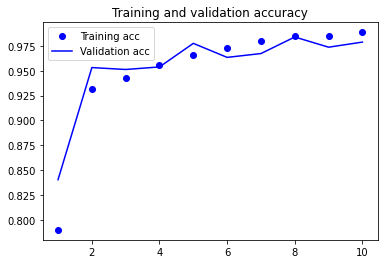

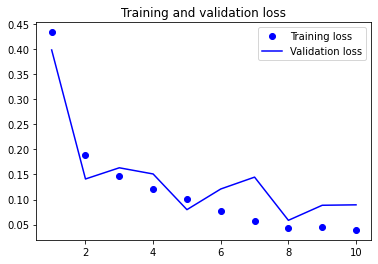

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

# 4. Result

Suppose, there is a video camera, and we should detect when people close their eyes.
<br/><br/>

First of all, it need to extract eye data from faces.
<br/><br/>
Using Dlib frontal face detector all of the 68 facial landmarks co-ordinates are detected and the co-ordinates are converted into numpy array.
<br/><br/>
Since the trained data includes eyebrows and eyes, it includes the following indexes like that.<br/>
Left index: 17,18,19,20,21,36,37,38,39,40,41 <br/>
Right: index: 22,23,24,25,26,42,43,44,45,46,47 <br/>
<img src="https://raw.githubusercontent.com/R4j4n/Eye-Gaze_and_Blink-detection-using-Neural-Network/master/MEDIA/crop.png" width="400" />

We apply by our picture <br/>
<img src="https://lh3.googleusercontent.com/fife/AAbDypD_42ew0EH3kILIxZTZQDgipInuRfXocRaSQpQ-RBQV7MXtm1CH5C7zbW-_eKGrFAQgVa09z0pG0uhBqvdJoEGXsEnArl2tmoKisR4qLv4LOBC_ZJrwz3j6OE1bv9FasPai9SqkJo_POOpclrMSGhKOp4Qft5YSFzdi7kI3i6LYu0xdu7SqIapkGjT5zA14aLqMGj5othSGA7-cb7jW2IiGNWF_o9onH7qQ7HnrrpARYDUPbX5xLmt8e1igE8pWyoNrhFGcwpLlU3k66lz6Tdgg19tJEdnNXIsoa-zARnNLd9N9AVHpXhESEkIoWnjHXKLPI2MIGW4nFvke6W-bnh8fuMdsLEWxHr_TOtPIO20rXPGaPlEFyDFqqz_NwmQmc5jM-kRa5RmSccBRgCFqV-9EwTIfCV-_pWbnyVeCMxz5a6fIGYlNlHNyivCdvTuvuuQMa5Mi1jAeKbKtldfr7Ud7ZmZY0xtewyeAtGoj173zRb6_W9QXfMic0kkuh54J-qrCZ7987BthFyVLgOjeVYuR54sBmRqZrpNoMT2kTw3eBI5kW-Jr2ydyBGU1wPcgt133xYwZrkS093am5gY9XRumxO4EXWC5wXTERdd_3gSy3qpYypIaC2bnMdKfv2dHQotGR1eRrqhX8h6cJTnuKWs1Fa2O7h1U5x0pMRP_dSQcDLovQJARCxgP07U9DfiLItp_0LgpZ35GPcEcs8x8BE0iQhwGOyBB_aS6E59-PTh_68DlEIoVl0cFv2pONPg-lyKeRrVmtO28USUimErGKS3a6BDZlKzZCsyPhHwh5WxkS_WeRTDnJZmaijk7IKKtZ3WIXtghRzQ-7O2R7i9FCSTShZ0WaxEZGZP6xOtA8ob3nNQC0Coy24TZ-iBZwXTo8qNX2w22Xcvp8_Ncj5l8ULigaTTb3FAHZnRXOJZuUmZlsL8pC1FPsRftn94JOmA0auXUiNJ1gK3erjSzNhlo-onu9Rb3OK06HwjN22IwMrTX3a66TWbvUK30t2w3nBmKxKKt1BJK2KRFg9vm1IyQc60_me3nxAzRbKTKH6GM9vQDak-4LCnL3fbJh40w7ha5aLP83IpYz0J-qqdabmdqtBSD5Kt_KFhFW23s2q0BiIAX8uTrx8UuaD3gnF5yQeU_gMpMoo5n-grDb253Ad8FMIP7lXW56h6gaOGohookyZZZWT7P-FYCk1NuuIP2ZnngB_RunR-Jt2jh9EKD8JX4PJfg9IdvP-c8kzp_kBoNT83xN692TAT9J8qPcBtRF6XjJyO_r2t1uSwayRjn0EtbY-zSmwo4PrhotU09eX8CkA20vmvLrLKdq-Jmyu7ZE7NDLsr8scAMhMuVLsJab7x-7FbzqQVM2YO_iquTBj-kRTGD9rEkXjPL65kq1KkH__OfI9EgROaLVPwwRS6kBRnnSEbxfIh_F_QKJL18O9f63bSfCD4PUIpXNFqwlJEKdlJcvF49eLDw1A=w1920-h937" width="400" />

After process data, we could image data like that

<img src="https://lh3.googleusercontent.com/fife/AAbDypB0CpcekeR62n4ptqIIJdbLgnIMweyfKWiG8mEDp6xD5UgvaCLI5WGY2bugQA-A0BodUcIdWFRaedQrLENH7Y5GcCFCYXV6Gc_krSaCuGSsgB3HGG9Lb_LECZDYyycKFTBv2-8lrx2utp6famgYGIS-7VSiVMg2ecdXVHosItp3MRT3tR2WmDODpeR5v9_i-w0Himdy-RJgGbA1FEYDhlLChWPEkFnRF1zrTxRnlDwolPWzJ1h3Dayv7y5PFE08Q_RURGb_r3kccoTAe1JkOolabxwDuD7E0Avat3ucHr2jJWfuAUvaRgUQdRuxNKiSDh8gxaixiyHaOWq535sekqPhnwd5X9Jivn-W5gWhBbzAYR1ysVv5vaLLdMP8zxPNkWHm7zdUsaZPJdICv6KUdTx97TQ07qsTh_wvdDIl2pu2Tqm4JHQ08bSsZ4PDlgHafiivNtSo71aGdZQxquJuDD8m_1CI2PQel4H75bILnOcmHQV1vREx7K4k0-xvnoS5rF_2PpwfBUSTjzaaoKA_bjC7UC5TrP1loR_A0Owt4A2RbmlAH4YalLl6iGj-GsYZIeLqMxSYS-qXwv-nNfimXnzO3xnwFcFw0UYczYC_ICCjbaL8fZVMJSTFYEXY5InS42J9x3dDG9jChHWxnKhdg85SRMyGMo-2nLBRusclQ0ZWT2vfCSQCgJNtEgWdzYIOQ5IQSEA4nU5hQ-KEozw1O0XyfaWvFoh2pzxw7UdAoG4kBalNu55CTRDeISccSQ87rnRgUQ7RRV_oFIzhcu4XBQ3tspzFJgxUvadbU8U72E-FIWhCL4N4s2s5Rwj4P8-iZ1RxANLnMujYFbjvVVx8mUWVj5_-otrai3C9dzYo_uP2vdHvoDTy3iy1lUnpdz4P2CAm7lb2xso18HUENXxWv0B3yQt35_LKIrzR4pAZghB9N-wkhF4Kj_Bkg0TUYRZDl9G7ZZyy_1Opa67IKGF8aDulMyw8izzHXixc6WpZXUDooXfg8YFb5LMJjCtHTVpQ0k3BMasDTs6kMBsPvU1GAeDnNgzNadd0W3vUJ3AoRLWWfEOMaMZUG7n2y1JBEScymqh8XD2tIEOAp8pwc_WuDW_egkghsXY_piNw6WSKRBxvBwPPFFP8avxcZG95e3Sf0zW_jJ2QxwlKE_vCpWz8ajlXCPABoL5stYNqiB6o6nQyZbjf1_VsmWBngJj53RXrvQO6SoFqXZxK4ha3L9wyyG2-KmcLiMHOUnYu3W44T8Tku8ac1pH4eqre48bpLK1I4vuY61drB743fkwUtCfLLY18izj_4gt_Qiy_hQkkoVqz-vQbybZibFKMpcoVsa4fvb3DBhIN_PQ_W7bj0_Zd8la8e8G1j2TgsyPe3k5pJFninBWXViC53yj0YtcD08r9OdmLXt1wYkCaIeT_PZA42BEAQ-MqecZfKHq8cm8a7CZjWWLvs-HCFRpi5TJTF0GBE8eQF0FhIw=w1920-h937" />


In [ ]:
  # image extract python
from google.colab import drive
import cv2, dlib, glob
import numpy as np
from imutils import face_utils
from PIL import Image
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image


left_eye_index = [17, 18, 19, 20, 21, 36, 37, 38, 39, 40, 41]
right_eye_index = [22, 23, 24, 25, 26, 42, 43, 44, 45, 46, 47]

IMG_SIZE = (56, 64)
B_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/MyDrive/ai teamproject/shape_predictor_68_face_landmarks.dat')

def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect  

for filename in glob.glob('/content/gdrive/MyDrive/ai teamproject/dataset/faces/*'):
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    for face in faces:  

      shapes = predictor(gray, face)
      
    # for n in range(36,42):
    for n in left_eye_index:
      x = shapes.part(n).x
      y = shapes.part(n).y

      next_point = n+1
      if n==41:
        next_point = 36 
            
      x2 = shapes.part(next_point).x
      y2 = shapes.part(next_point).y
      
      cv2.line(image,(x,y),(x2,y2),(0,69,255),2)

    for n in right_eye_index:
      x = shapes.part(n).x
      y = shapes.part(n).y
      next_point = n+1
            
      if n==47:
        next_point = 42 
            
      x2 = shapes.part(next_point).x
      y2 = shapes.part(next_point).y
      cv2.line(image,(x,y),(x2,y2),(153,0,153),2)
      
    shape_handle = face_utils.shape_to_np(shapes)
   
    eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shape_handle[left_eye_index])
    eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shape_handle[right_eye_index])
   
    eye_img_l_view = cv2.resize(eye_img_l, dsize=(128,112))
    eye_img_l_view = cv2.cvtColor(eye_img_l_view,cv2.COLOR_BGR2RGB)
    eye_img_r_view = cv2.resize(eye_img_r, dsize=(128,112))
    eye_img_r_view = cv2.cvtColor(eye_img_r_view, cv2.COLOR_BGR2RGB)
   
    eye_blink_left = cv2.resize(eye_img_l.copy(), B_SIZE)
    eye_blink_right = cv2.resize(eye_img_r.copy(), B_SIZE)
   
    plt.imshow(eye_img_l_view, interpolation='nearest')
    plt.show()
    ri = random.randint(0, 100000)
    
    plt.imsave(process_path + str(ri) + "l.jpg", eye_img_l_view)
    plt.imsave(process_path + str(ri) + "r.jpg", eye_img_r_view)


To check specific result, we seperate test case like that:

<ol>
  <li>Test data using kaggle</li>
  <li>face data with hair X, glass X </li>
  <li>face data with hair O, glass X</li>
  <li>face data with hair O, glass O</li>
  <li>face data with hair X, glass O</li>
</ol>

## Case1: Kaggle data

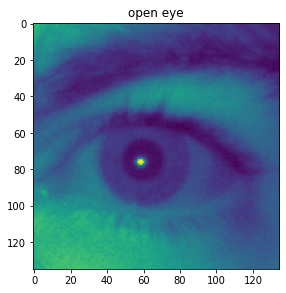

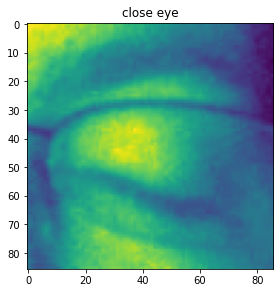

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open eyes
open_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test/open/forward_look (1118).png')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('open eye')
plt.imshow(open_sample)


close_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test/close/eye_closed(48).png')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('close eye')
plt.imshow(close_sample)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   target_size =image_shape[:2],
                                                    batch_size=32,
                                                   shuffle=False,
                                                   color_mode="grayscale",
                                                   class_mode='binary'
                                                  )

lmodel = load_model('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')
test_loss_1, test_acc_1 = lmodel.evaluate(test_generator)
print("\n\n\t======== Case1: Kaggle Data ========")
print("\nResult => test_acc:", test_acc_1, "test_loss:", test_loss_1)

Found 23 images belonging to 2 classes.
1/1 [==============================] - 0s 216ms/step - loss: 0.0665 - acc: 0.9565


	======== Case1: Kaggle Data ========

Result => test_acc: 0.95652174949646 test_loss: 0.06653621047735214


## Case2: No hair, No glass

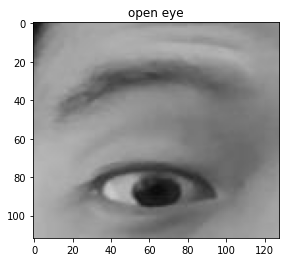

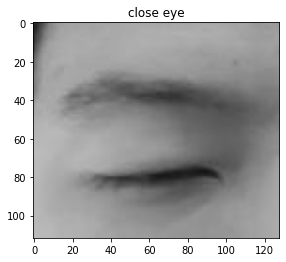

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open eyes
open_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_2/open/23463l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('open eye')
plt.imshow(open_sample)


close_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_2/close/75554l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('close eye')
plt.imshow(close_sample)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path_2,
                                                   target_size =image_shape[:2],
                                                    batch_size=32,
                                                   shuffle=False,
                                                   color_mode="grayscale",
                                                   class_mode='binary'
                                                  )
lmodel = load_model('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')
test_loss_2, test_acc_2 = lmodel.evaluate(test_generator)
print("\n\n\t======== Case2: No hair, no glass ========")
print("\nResult => test_acc:", test_acc_2, "test_loss:", test_loss_2)

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 222ms/step - loss: 0.3859 - acc: 0.9000


	======== Case2: No hair, no glass ========

Result => test_acc: 0.8999999761581421 test_loss: 0.3858860433101654


## Case3: Hair, No glass

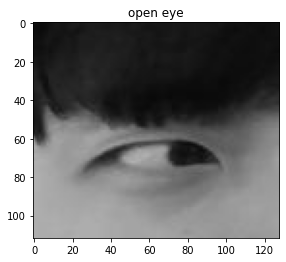

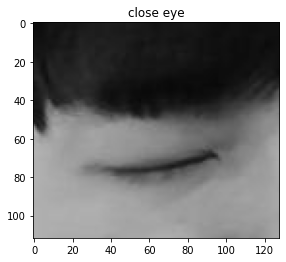

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open eyes
open_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_3/open/18183l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('open eye')
plt.imshow(open_sample)


close_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_3/close/14183l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('close eye')
plt.imshow(close_sample)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path_3,
                                                   target_size =image_shape[:2],
                                                    batch_size=32,
                                                   shuffle=False,
                                                   color_mode="grayscale",
                                                   class_mode='binary'
                                                  )
lmodel = load_model('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')
test_loss_3, test_acc_3 = lmodel.evaluate(test_generator)
print("\n\n\t======== Case3: hair, no glass ========")
print("\nResult => test_acc:", test_acc_3, "test_loss:", test_loss_3)

Found 20 images belonging to 2 classes.
1/1 [==============================] - 0s 203ms/step - loss: 1.2242 - acc: 0.8500


	======== Case3: hair, no glass ========

Result => test_acc: 0.8500000238418579 test_loss: 1.2241711616516113


## Case4: Hair, Glass

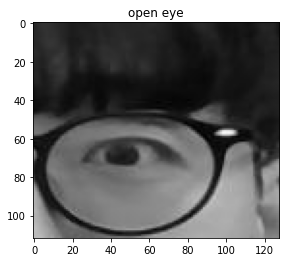

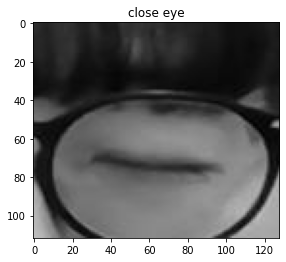

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open eyes
open_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_4/open/9169r.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('open eye')
plt.imshow(open_sample)


close_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_4/close/5831r.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('close eye')
plt.imshow(close_sample)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path_4,
                                                   target_size =image_shape[:2],
                                                    batch_size=32,
                                                   shuffle=False,
                                                   color_mode="grayscale",
                                                   class_mode='binary'
                                                  )
lmodel = load_model('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')
test_loss_4, test_acc_4 = lmodel.evaluate(test_generator)
print("\n\n\t======== Case4: hair, glass ========")
print("\nResult => test_acc:", test_acc_4, "test_loss:", test_loss_4)

Found 24 images belonging to 2 classes.
1/1 [==============================] - 0s 239ms/step - loss: 13.8615 - acc: 0.4167


	======== Case4: hair, glass ========

Result => test_acc: 0.4166666567325592 test_loss: 13.861473083496094


## Case5: No hair, Glass

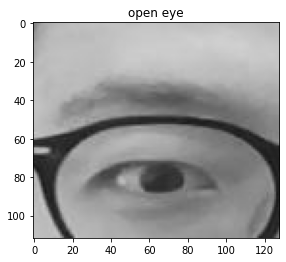

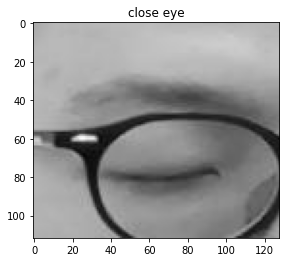

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open eyes
open_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_5/open/4367l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('open eye')
plt.imshow(open_sample)


close_sample = mpimg.imread('/content/gdrive/MyDrive/ai teamproject/dataset/test_5/close/30572l.jpg')
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.title('close eye')
plt.imshow(close_sample)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path_4,
                                                   target_size =image_shape[:2],
                                                    batch_size=32,
                                                   shuffle=False,
                                                   color_mode="grayscale",
                                                   class_mode='binary'
                                                  )
lmodel = load_model('/content/gdrive/MyDrive/ai teamproject/rnn_model.h5')
test_loss_5, test_acc_5 = lmodel.evaluate(test_generator)
print("\n\n\t======== Case4: hair, glass ========")
print("\nResult => test_acc:", test_acc_5, "test_loss:", test_loss_5)

Found 24 images belonging to 2 classes.
1/1 [==============================] - 0s 195ms/step - loss: 13.8615 - acc: 0.4167


	======== Case4: hair, glass ========

Result => test_acc: 0.4166666567325592 test_loss: 13.861473083496094


## Conclusion

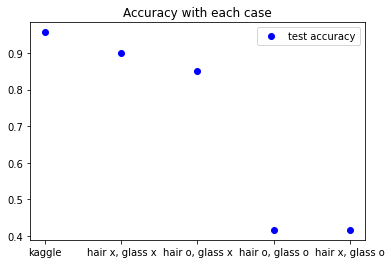

In [167]:
import matplotlib.pyplot as plt

case_range = ["kaggle", "hair x, glass x", "hair o, glass x", "hair o, glass o","hair x, glass o"]
test_acc_list = [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5]

plt.plot(case_range, test_acc_list, 'bo', label='test accuracy') 
plt.title('Accuracy with each case') 
plt.legend()

plt.show()

Glass with eye makes hard to expect result

# 5. Simple Demo

https://drive.google.com/file/d/165XmuxIT1rRtG8iEgl01cpDqlteWhztw/view?usp=sharing


# 6. Suggestion

<ol>
  <li></li>
</ol>



# 7. Roles


Bumseung Kim - Team leader
<ul>
  <li>Data processing</li>
  <li>Write documentation</li>
  <li>Prepare presentation</li>
  <li>Presenter</li>
</ul>

<br/>
Minseon Song - Team member
<ul>
  <li>Plan project and topic</li>
  <li>Model implementation</li>
  <li>Research</li>
  <li>Make demo version</li>
</ul>
<br/>
You can see all codes from github
github: https://github.com/itmAIProject